In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
from matplotlib import rcParams

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/home/py_3/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/py_3/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home/py_3/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.3 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
adata = sc.read_h5ad("3.scanpy_umap.h5ad")
adata

AnnData object with n_obs × n_vars = 80000 × 847 
    obs: 'cell_group', 'cell_subject', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [3]:
is_B = adata.obs['louvain']
is_B = is_B.replace(['0','1','2','3','4','5','6','7','8','9',
                     '10','12','14','15'],'yes')
is_B = is_B.replace(['11','13','16','17'],'no')
adata.obs['is_B'] = is_B
adata

AnnData object with n_obs × n_vars = 80000 × 847 
    obs: 'cell_group', 'cell_subject', 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'is_B'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [4]:
B_barcode = adata[adata.obs['is_B'] == 'yes', :]
B_barcode

View of AnnData object with n_obs × n_vars = 73687 × 847 
    obs: 'cell_group', 'cell_subject', 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'is_B'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [5]:
adata = sc.read_10x_h5("/mnt/d/project5_covid19/ABFC20200198-01/group/S11/outs/filtered_feature_bc_matrix.h5", 
                       genome=None, gex_only=True)
adata.var_names_make_unique()
adata

reading /mnt/d/project5_covid19/ABFC20200198-01/group/S11/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 84542 × 33538 
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
anno = pd.read_csv("/mnt/d/project5_covid19/ABFC20200198-01/group/S11/outs/barcodes.csv", index_col=0)
adata.obs['cell_group'] = anno['cell_group']
adata.obs['cell_subject'] = anno['cell_subject'] 

In [7]:
adata.obs['is_B'] = adata.obs_names

adata.obs['is_B'] = adata.obs['is_B'].replace(B_barcode.obs_names,'yes')

adata = adata[adata.obs['is_B'] == 'yes', :]

adata

View of AnnData object with n_obs × n_vars = 73687 × 33538 
    obs: 'cell_group', 'cell_subject', 'is_B'
    var: 'gene_ids', 'feature_types', 'genome'

normalizing counts per cell
    finished (0:00:01)


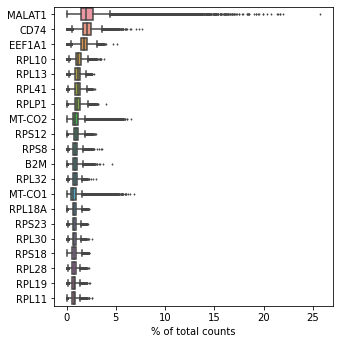

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
sc.pp.filter_cells(adata, min_genes=200) 
sc.pp.filter_genes(adata, min_cells=3)     
adata

Trying to set attribute `.obs` of view, copying.


filtered out 14520 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 73687 × 19018 
    obs: 'cell_group', 'cell_subject', 'is_B', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

... storing 'cell_group' as categorical
... storing 'cell_subject' as categorical
... storing 'is_B' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


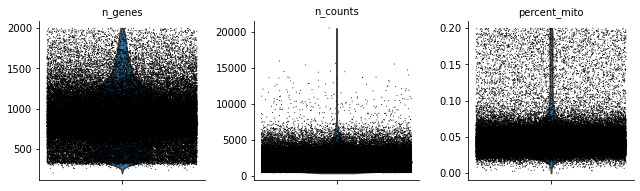

In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata 

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


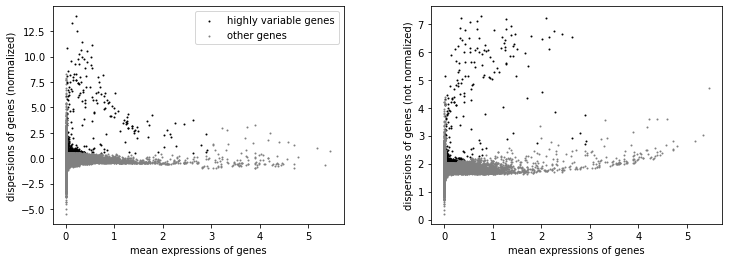

,gene_ids,feature_types,genome,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,34,False,0.001890,1.701904,-0.529424
AL669831.5,ENSG00000237491,Gene Expression,GRCh38,460,False,0.027983,1.863958,0.005434
FAM87B,ENSG00000177757,Gene Expression,GRCh38,5,False,0.000567,2.314476,1.492368
LINC00115,ENSG00000225880,Gene Expression,GRCh38,849,False,0.055874,1.945278,0.273831
FAM41C,ENSG00000230368,Gene Expression,GRCh38,195,False,0.010546,1.598785,-0.869767
...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,59,False,0.004316,2.193284,1.092374
AC004556.1,ENSG00000276345,Gene Expression,GRCh38,705,False,0.036895,1.571964,-0.958288
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,2233,True,0.403004,4.524041,5.690116
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,1597,True,0.420974,5.649707,8.115311


In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.var

In [13]:
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 73687 × 868 
    obs: 'cell_group', 'cell_subject', 'is_B', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:05)


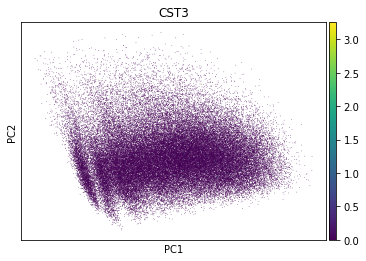

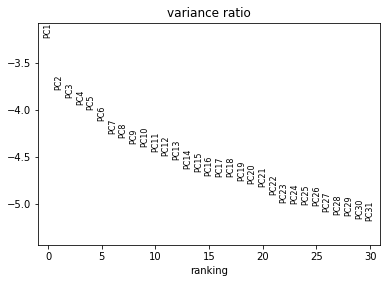

In [14]:
# PCA
sc.tl.pca(adata, svd_solver='arpack') 
sc.pl.pca(adata, color='CST3')
sc.pl.pca_variance_ratio(adata, log=True)

In [15]:
adata.write("5.scanpy_pca_B.h5ad")

In [16]:
# Clustering
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=10)
sc.tl.umap(adata)
sc.tl.louvain(adata)
sc.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:02:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:01:39)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:25)


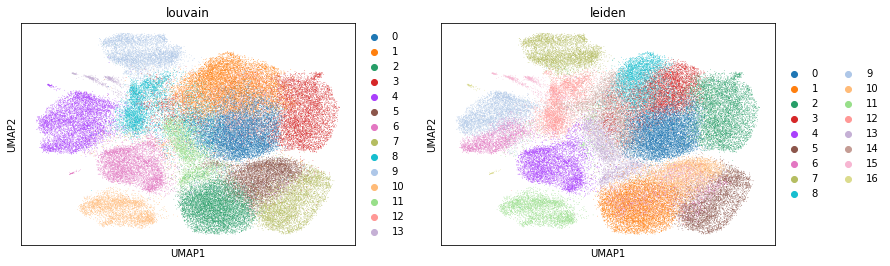

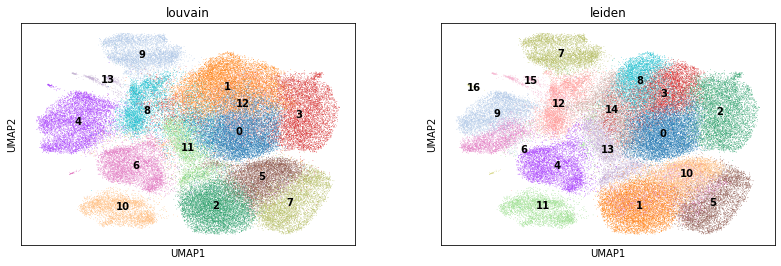

In [17]:
sc.pl.umap(adata, color=['louvain', 'leiden'])
sc.pl.umap(adata, color=['louvain', 'leiden'], legend_loc='on data')
# sc.pl.umap(adata, color=['cell_subject','cell_group'])

In [18]:
control = adata[adata.obs['cell_group'] == 'N', :]
cases = adata[adata.obs['cell_group'] == 'S', :]

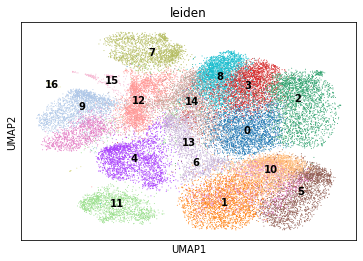

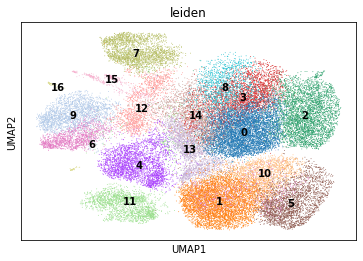

In [19]:
sc.pl.umap(control, color=['leiden'], legend_loc='on data')
sc.pl.umap(cases, color=['leiden'], legend_loc='on data')

In [20]:
adata.write("5.scanpy_umap_B.h5ad")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:20)


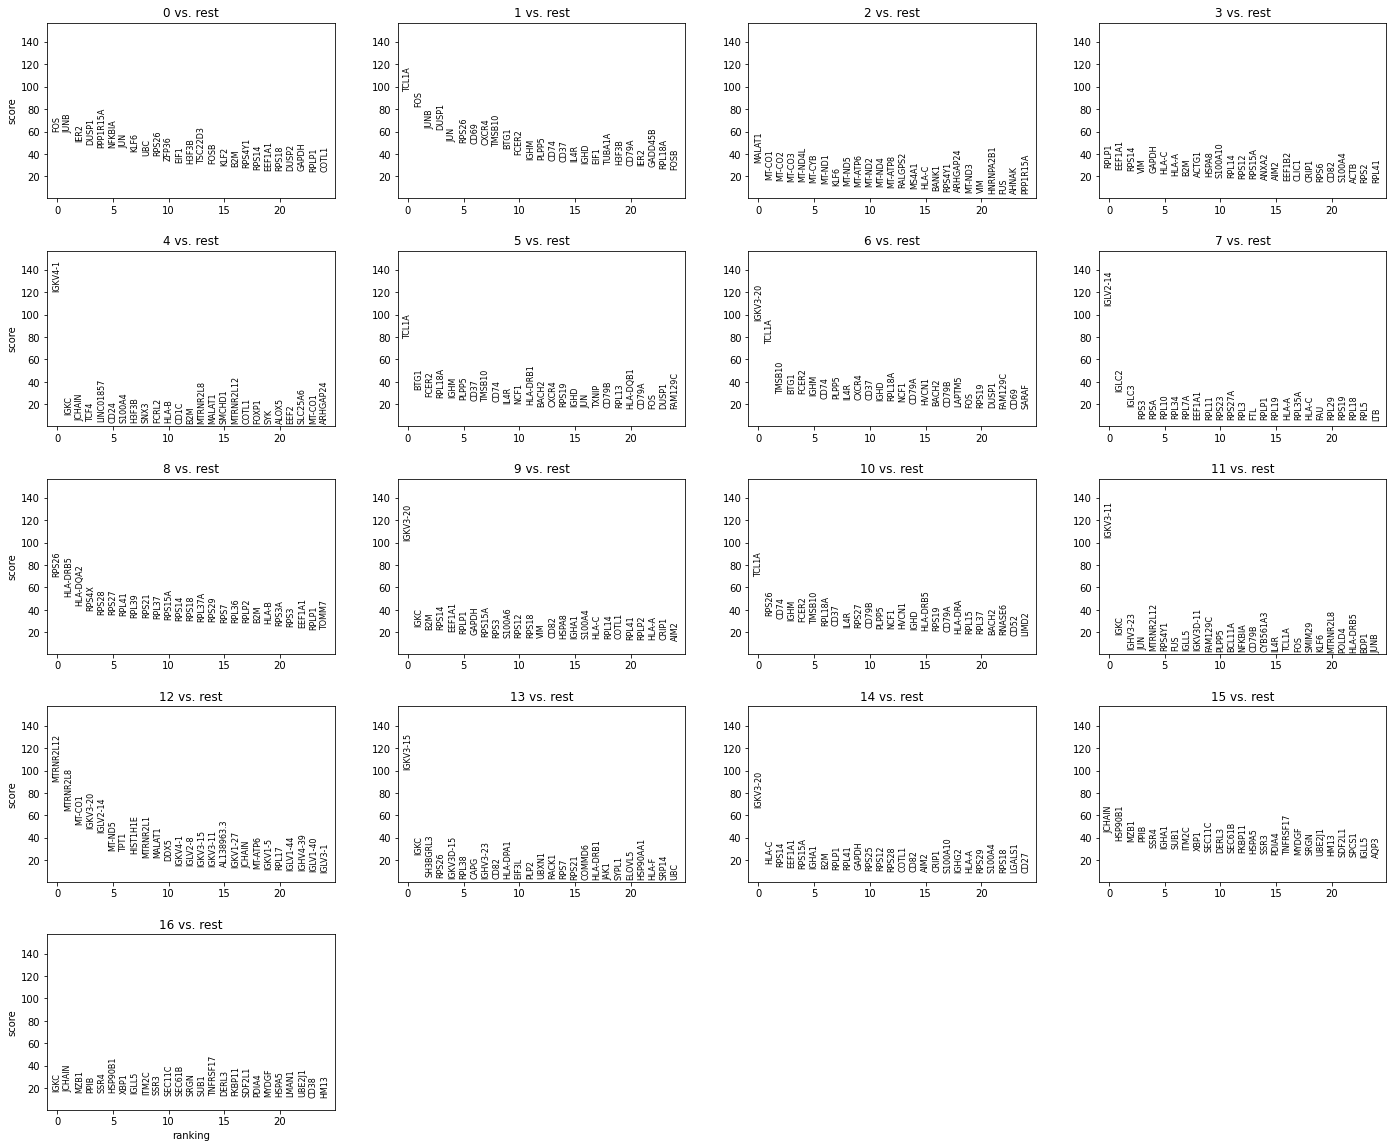

In [21]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25)

In [22]:
with pd.ExcelWriter('5.canpy_leiden_markers.xlsx') as writer:
    for i in range(17):
        print(i)
        temp = sc.get.rank_genes_groups_df(adata, group=str(i))
        temp.to_excel(writer, sheet_name=str(i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


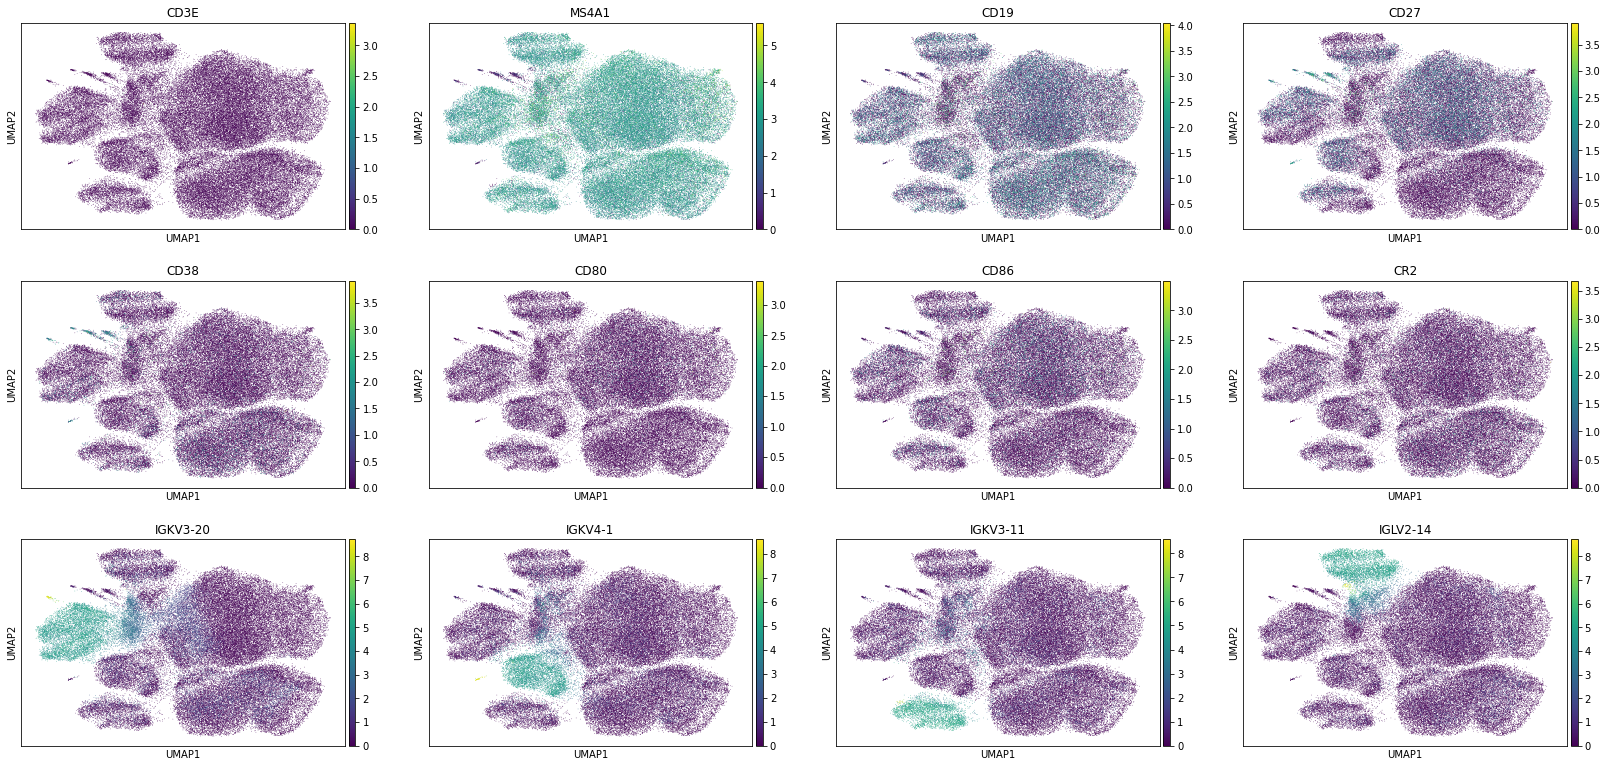

In [23]:
sc.pl.umap(adata, color=['CD3E', 'MS4A1', 'CD19', 'CD27', 
                         'CD38', 'CD80', 'CD86', 'CR2', 
                         'IGKV3-20', 'IGKV4-1', 'IGKV3-11', 'IGLV2-14'])

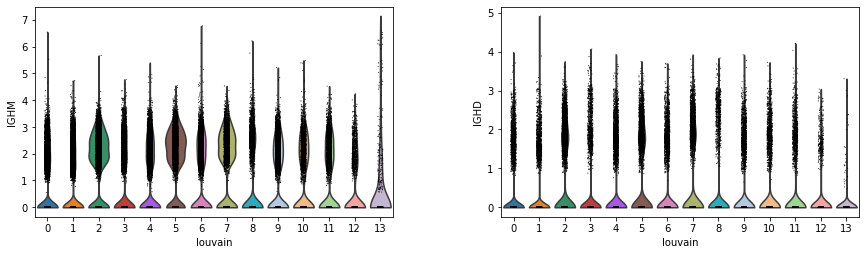

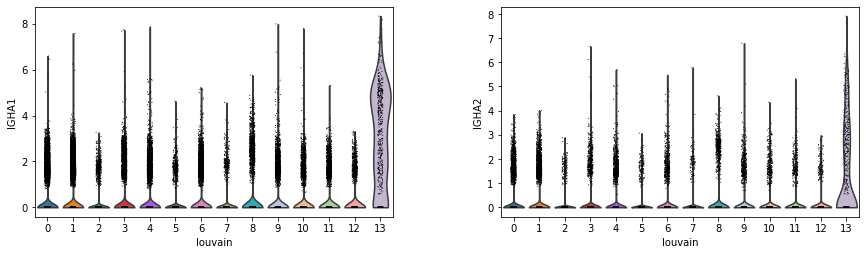

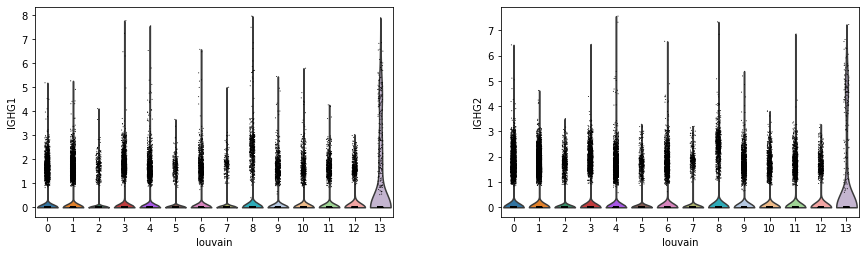

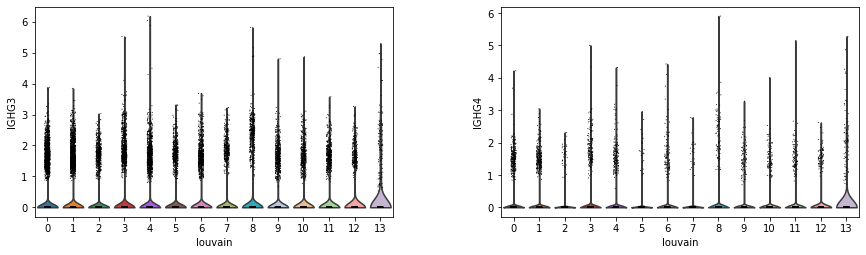

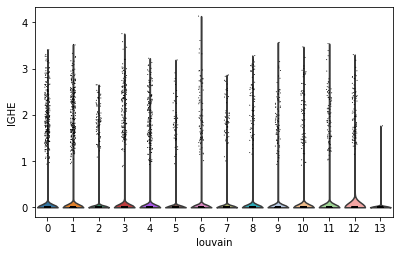

In [24]:
sc.pl.violin(adata, ['IGHM', 'IGHD'], groupby='louvain')
sc.pl.violin(adata, ['IGHA1', 'IGHA2'], groupby='louvain')
sc.pl.violin(adata, ['IGHG1', 'IGHG2'], groupby='louvain')
sc.pl.violin(adata, ['IGHG3', 'IGHG4'], groupby='louvain')
sc.pl.violin(adata, ['IGHE'], groupby='louvain')